In [50]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [51]:
import numpy as np
import pandas as pd

In [52]:

import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [53]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [54]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [55]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [56]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [57]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [58]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [59]:
inspector = inspect(engine)

In [60]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [61]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [62]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

maxdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
maxdate = list(np.ravel(maxdate))[0]

maxdate2 = dt.datetime.strptime(maxdate, "%Y-%m-%d")
maxdate2 = maxdate2.timetuple()

year = maxdate2[0]-1
month = maxdate2[1]
day = maxdate2[2]
last12m = dt.date(year, month, day)
last12m

datetime.date(2016, 8, 23)

In [63]:
# Perform a query to retrieve the data and precipitation scores

rain = session.query(Measurement.date, Measurement.prcp).\
   filter(Measurement.date >= last12m).\
   order_by(Measurement.date).all()


In [64]:
# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_data=pd.DataFrame(rain)
prcp_data=prcp_data.dropna()
prcp_data.head()


,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79


In [65]:
# Sort the dataframe by date

prcp_data.set_index('date', inplace=True)
prcp_data.sort_values('date', ascending =False)
prcp_data.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


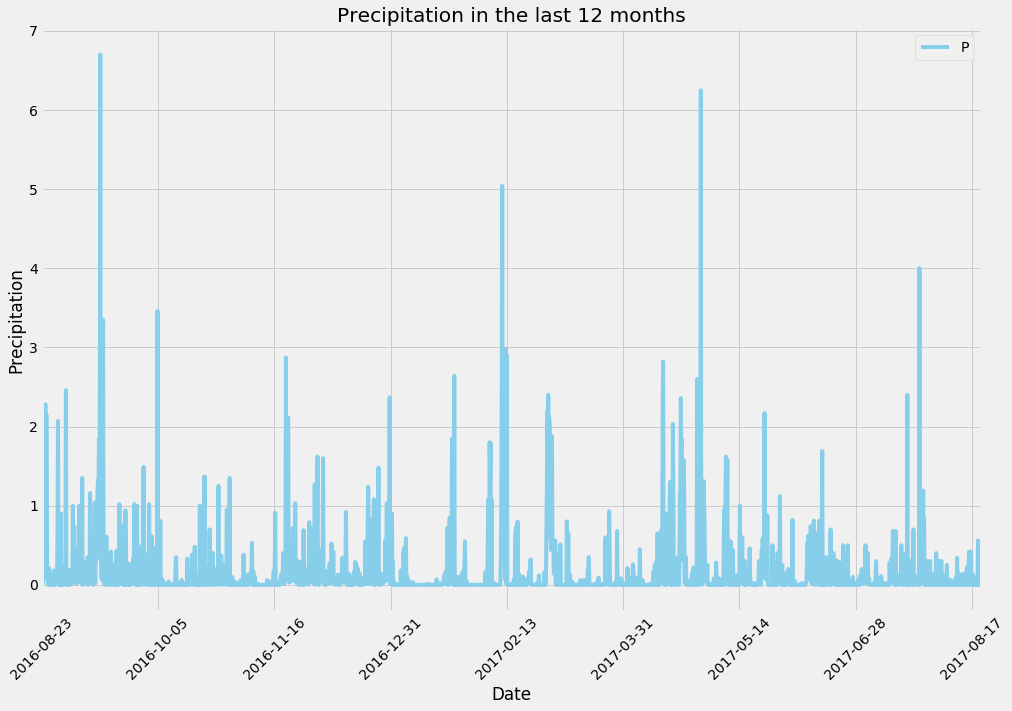

In [66]:
# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots(figsize = (15, 10))
prcp_data.plot(ax = ax, color = 'skyblue')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation')
ax.set_title("Precipitation in the last 12 months")
plt.xticks(rotation='45')
plt.legend('Precipitation')
# plt.xticks([])
# Save the Figure
plt.savefig("Precipitation_Analysis.png")
# Show the Figure
plt.show()

In [67]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats_prcp= prcp_data.describe()
stats_prcp

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [68]:
# Design a query to show how many stations are available in this dataset?
stations =  session.query(Station.station).count()
stations

9

In [69]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [70]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

active_st = "USC00519281"
Temp_highest = session.query(func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').first()
Temp_lowest = session.query(func.min(Measurement.tobs)).filter(Measurement.station=='USC00519281').first()
Temp_avg =  session.query(func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').first()                            
 
print(f"Highest Temperature is {Temp_highest}")
print(f"Lowest Temperature is {Temp_lowest}") 
print(f"Average Temperature is {Temp_avg}")                          

Highest Temperature is (85.0,)
Lowest Temperature is (54.0,)
Average Temperature is (71.66378066378067,)


In [71]:
St_highest = session.query(func.max(Measurement.tobs)).\
             filter(Measurement.station == 'USC00519281').first()
St_highest

(85.0)

In [72]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


temp_obs = (session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= last12m).\
            filter(Measurement.station == active_st).order_by(Measurement.date)).all()


In [73]:
# Save the query results as a Pandas DataFrame
Temp= pd.DataFrame(temp_obs)
Temp.set_index('date').head()

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


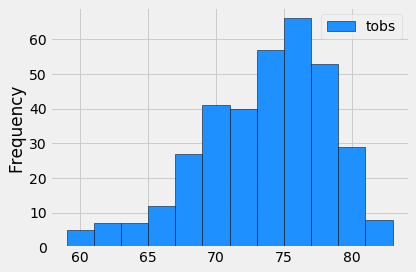

In [74]:
# Histogram 

Temp.plot.hist(bins=12, color='dodgerblue', ec='black')
plt.tight_layout()


In [75]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-8-23', '2017-8-23'))

[(58.0, 74.14387974230493, 87.0)]


In [76]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

depart_date=dt.date(2017,7,20)
arrive_date=dt.date(2017,7,30)
# lastyear = dt.timedelta(days=365)
vacy_time = calc_temps(depart_date, arrive_date)
vacy_time

[(72.0, 78.8, 84.0)]

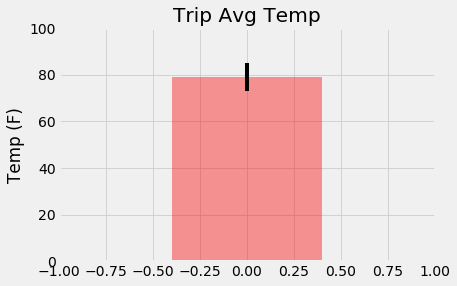

In [77]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = vacy_time [0][0]
avg_temp = vacy_time [0][1] 
max_temp = vacy_time [0][2] 
error = max_temp-min_temp 
plt.bar(0,avg_temp, yerr=error/2, color = 'red', alpha = .4) 
plt.ylim(0, 100) 
plt.xlim(-1, 1)
plt.title('Trip Avg Temp') 
plt.ylabel('Temp (F)') 
# plt.xticks([]) 
plt.grid(alpha=.8)


In [78]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = dt.date(2017,7,20)
end_date = dt.date(2017,7,30)
data = [Station.station, Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]

results = session.query(*data).filter(Measurement.station==Station.station).filter(Measurement.date>=start_date).\
         filter(Measurement.date<=end_date).group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
results

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  8.04),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.6800000000000002),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.6600000000000001),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  1.1099999999999999),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.38),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.11),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.01)]

In [79]:
Vacation_analysis = pd.DataFrame(np.array(results)) 

Vacation_analysis = Vacation_analysis.rename(columns={0: "Station",
                                                     1: "Location", 
                                                     2: "Total Precipitation",
                                                     3: "Latitude", 
                                                     4: "Longitude", 
                                                     5: "Elevation"}) 
Vacation_analysis

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,8.04
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,1.6800000000000002
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9,1.6600000000000001
3,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,1.1099999999999999
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.38
5,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.11
6,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9,0.01


In [83]:
# Vacation days- (2017-7-20,2017- 7-30)
daily_n=[]
dn=0
dates=[]
for day in range (20,30):
    if day<10:
        
        dn = daily_normals(f"07-0{day}")
        daily_n.append(f"2017-07-0{day}")
    else:
        dn=daily_normals(f"07-{day}")
        daily_n.append(list(np.ravel(dn)))
        dates.append(f"2017-07-{day}")

daily_df=pd.DataFrame(list(daily_n), columns=['tmin','tavg','tmax'])
daily_df['dates']=dates
daily_df=daily_df.set_index('dates')
daily_df.head()

,tmin,tavg,tmax
dates,,,
2017-07-20,69.0,75.462963,82.0
2017-07-21,69.0,76.924528,83.0
2017-07-22,69.0,75.788462,81.0
2017-07-23,70.0,76.203704,84.0
2017-07-24,69.0,76.555556,81.0


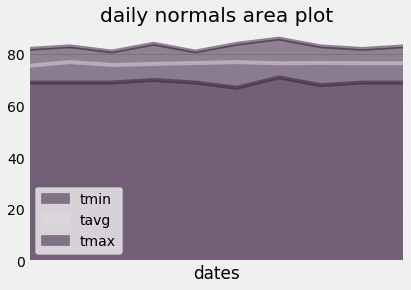

In [84]:
# Plot the daily normals as an area plot with `stacked=False`
daily_df.plot(kind='area',stacked=False, alpha=0.5, colormap='twilight_shifted',title='daily normals area plot')
[ax.legend(('tmin','tavg','tmax'),loc='lower left') for x in plt.gcf().axes]
plt.xticks([])
plt.savefig("Daily Normals")
plt.show()